In [1]:
!pip install torch torchvision torchaudio
!pip install rdkit-pypi
!pip install transformers
!pip install datasets
!pip install safe-mol

In [2]:
import pandas as pd

In [3]:
zinc_data_path = './zinc250k.csv'
zinc_df = pd.read_csv(zinc_data_path)

zinc_df.head()

,smiles,qed,sa,parp1,fa7,5ht1b,braf,jak2
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,0.702012,0.879545,8.9,7.2,9.4,9.6,8.5
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,0.928975,0.729777,8.6,7.9,8.6,9.1,8.3
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,0.599682,0.836596,9.7,7.8,10.1,10.2,8.6
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,0.690944,0.797472,9.9,7.6,9.9,9.7,9.2
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,0.789027,0.662758,9.4,7.8,6.3,7.9,8.7


## Convert SMILES to SAFE

In [4]:
import safe as sf
import datamol as dm

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


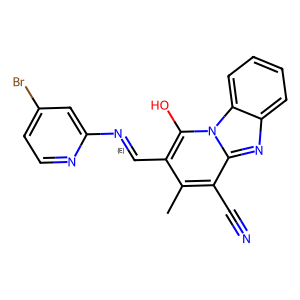

In [5]:
celecoxib = zinc_df['smiles'][8]
celecoxib_mol = dm.to_mol(celecoxib)

display(dm.to_image(celecoxib_mol))

In [6]:
safe_str = sf.encode(celecoxib_mol, canonical=True, slicer='attach')

print(safe_str)
print(f"Representation using {len(safe_str.split('.'))} fragments")


c14c9c%19n2c(nc3c%12c%22c8c6c32)c1%13.c1%11nc%23c%20c%16c1%18.C4%217%14.C=%179%10.N=%17%11.O%15%19.C#5%13.Br%16.N#5.[H]7.[H]%14.[H]%21.[H]%10.[H]%18.[H]%20.[H]%23.[H]%15.[H]%12.[H]%22.[H]8.[H]6
Representation using 21 fragments


In [7]:
# Add 'safe' column to dataframe and convert smiles to safe
# zinc_df['safe'] = zinc_df['smiles'].apply(lambda x: sf.encode(dm.to_mol(x), canonical=True, slicer='attach'))

In [8]:
# Use a smaller piece of the dataset for the sake of time
zinc_df_small = zinc_df.head(1000).copy()
zinc_df_small['safe'] = zinc_df_small['smiles'].apply(lambda x: sf.encode(dm.to_mol(x), canonical=True, slicer='attach'))
zinc_df_small.head()

,smiles,qed,sa,parp1,fa7,5ht1b,braf,jak2,safe
0,CC(C)(C)c1ccc2occ(CC(=O)Nc3ccccc3F)c2c1,0.702012,0.879545,8.9,7.2,9.4,9.6,8.5,c1%20c%31c%17c2oc%14c%30c2c1%11.c1%27c%12c%18c...
1,C[C@@H]1CC(Nc2cncc(-c3nncn3C)c2)C[C@@H](C)C1,0.928975,0.729777,8.6,7.9,8.6,9.1,8.3,[C@@]14%13C5%12C%26%27C%11%22[C@@]%32%17C1%28%...
2,N#Cc1ccc(-c2ccc(O[C@@H](C(=O)N3CCCC3)c3ccccc3)...,0.599682,0.836596,9.7,7.8,10.1,10.2,8.6,N1%12C%14%22C%13%25C%34%17C16%27.c1%26c8c%18c%...
3,CCOC(=O)[C@@H]1CCCN(C(=O)c2nc(-c3ccc(C)cc3)n3c...,0.690944,0.797472,9.9,7.6,9.9,9.7,9.2,c15nc%16n2c1C%17%30C%14%32C%44%22C%26%13C2%41%...
4,N#CC1=C(SCC(=O)Nc2cccc(Cl)c2)N=C([O-])[C@H](C#...,0.789027,0.662758,9.4,7.8,6.3,7.9,8.7,C1%25=C%27N=C9[C@@]%294C12C%288C%31%20C%30%21C...


## Preprocessing

In [9]:
from transformers import GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch

In [32]:
class MoleculeDataset(Dataset):
    def __init__(self, input_ids, attention_mask):
        self.input_ids = input_ids
        self.attention_mask = attention_mask

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {"input_ids": self.input_ids[idx], "attention_mask": self.attention_mask[idx]}

In [33]:
# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

In [34]:
# Tokenize the SAFE strings
safe_strings = zinc_df_small['safe'].tolist()
encodings = tokenizer(safe_strings, return_tensors='pt', max_length=512, truncation=True, padding="max_length")
input_ids = encodings['input_ids']
attention_mask = encodings['attention_mask']

In [35]:
input_ids

tensor([[   66,    16,     4,  ..., 50256, 50256, 50256],
        [   58,    34, 12404,  ..., 50256, 50256, 50256],
        [   45,    16,     4,  ..., 50256, 50256, 50256],
        ...,
        [   34,  1507,    28,  ..., 50256, 50256, 50256],
        [   34, 23362,    46,  ..., 50256, 50256, 50256],
        [   58,    34, 12404,  ..., 50256, 50256, 50256]])

In [36]:
attention_mask

tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])

In [37]:
# Split the dataset
train_inputs, val_inputs, train_masks, val_masks = train_test_split(input_ids, attention_mask, test_size=0.2, random_state=42)

In [38]:
# Create datasets
train_dataset = MoleculeDataset(train_inputs, train_masks)
val_dataset = MoleculeDataset(val_inputs, val_masks)

In [40]:
train_dataset

## Defining the Model

Need to train this on some gpus...

In [ ]:
model = GPT2LMHeadModel.from_pretrained('gpt2')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [ ]:
epochs = 4
for epoch in range(epochs):
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss {loss.item()}")

## Evaluation